<a href="https://colab.research.google.com/github/Jammyeong/MachineLearningClass/blob/main/6thWeek/Tugas_ML_6_Online_Retailipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Impor Pustaka yang Diperlukan
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Memuat dan Membersihkan Data ---
df = pd.read_excel('/content/drive/MyDrive/smt akhir/ml/Online Retail.xlsx')

print(df.shape)

(541909, 8)


In [3]:
# Hapus baris di mana CustomerID tidak ada, karena kita tidak bisa mengelompokkan pelanggan anonim
df.dropna(subset=['CustomerID'], inplace=True)
print(df.shape)

# Ubah tipe data CustomerID menjadi integer
df['CustomerID'] = df['CustomerID'].astype(int)

(406829, 8)


In [4]:
# Hapus transaksi pengembalian barang (Quantity < 0) dan harga unit nol
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
print(df.shape)

# Ubah tipe data InvoiceDate menjadi datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Buat kolom TotalPrice (Harga Total)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

(397884, 8)


In [5]:
# Membuat Fitur RFM (Recency, Frequency, Monetary) ---

# Tentukan tanggal snapshot (satu hari setelah tanggal transaksi terakhir)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Hitung nilai RFM untuk setiap pelanggan
df_rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency: hari sejak pembelian terakhir
    'InvoiceNo': 'nunique',                                # Frequency: jumlah transaksi unik
    'TotalPrice': 'sum'                                    # Monetary: total nilai pembelian
})

# Ganti nama kolom agar lebih deskriptif
df_rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

print("\nContoh data RFM sebelum transformasi:")
print(df_rfm.head())


Contoh data RFM sebelum transformasi:
            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2          7        4310.00
12348            75          4        1797.24
12349            19          1        1757.55
12350           310          1         334.40


In [7]:
# Transformasi dan Penskalaan Data ---

# Menggunakan log1p untuk menghindari error jika ada nilai 0
df_rfm_log = np.log1p(df_rfm)

# Standarisasi data agar setiap fitur memiliki skala yang sama (mean=0, std=1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=df_rfm.index, columns=df_rfm.columns)

print("Contoh data RFM setelah penskalaan:")
print(rfm_scaled.head())

Contoh data RFM setelah penskalaan:
             Recency  Frequency  MonetaryValue
CustomerID                                    
12346       1.461993  -0.955214       3.706225
12347      -2.038734   1.074425       1.411843
12348       0.373104   0.386304       0.716489
12349      -0.623086  -0.955214       0.698739
12350       1.424558  -0.955214      -0.618962


In [8]:
# Membuat dan Mengevaluasi Model K-Means ---

inertia = []
silhouette = []
calinski = []
davies = []
K = range(2, 11) # Menentukan rentang jumlah cluster yang akan diuji (2 hingga 10)

for k in K:
    # Inisialisasi dan latih model K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)

    # Simpan metrik evaluasi
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, kmeans.labels_))
    calinski.append(calinski_harabasz_score(rfm_scaled, kmeans.labels_))
    davies.append(davies_bouldin_score(rfm_scaled, kmeans.labels_))

In [9]:
# Menampilkan Hasil Clustering K-Means ---

# Pilih jumlah cluster terbaik berdasarkan analisis (k=4 untuk K-Means)
final_k = 4

# Buat dan latih model K-Means final
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled)

# Tambahkan kolom 'Cluster' ke dataframe RFM asli untuk melihat hasilnya
df_rfm['Cluster'] = kmeans_final.labels_

# Tampilkan beberapa pelanggan dari setiap cluster
print("HASIL AKHIR CLUSTERING (K-Means dengan k=4)")
print("\nJumlah Pelanggan per Cluster:")
print(df_rfm['Cluster'].value_counts())

HASIL AKHIR CLUSTERING (K-Means dengan k=4)

Jumlah Pelanggan per Cluster:
Cluster
3    1612
2    1173
0     837
1     716
Name: count, dtype: int64


In [10]:
# Membuat dan Mengevaluasi Model Agglomerative Clustering ---

silhouette_agg = []
calinski_agg = []
davies_agg = []

for k in K:
    # Inisialisasi dan latih model Agglomerative Clustering
    agg_cluster = AgglomerativeClustering(n_clusters=k)
    labels = agg_cluster.fit_predict(rfm_scaled)

    # Simpan metrik evaluasi
    silhouette_agg.append(silhouette_score(rfm_scaled, labels))
    calinski_agg.append(calinski_harabasz_score(rfm_scaled, labels))
    davies_agg.append(davies_bouldin_score(rfm_scaled, labels))

In [15]:
# Menerapkan Model Final Agglomerative Clustering dan Menampilkan Hasil ---

# Berdasarkan analisis metrik, k=2 memberikan skor terbaik untuk Agglomerative Clustering
final_k = 3

# Buat model final dengan 2 cluster
agg_final = AgglomerativeClustering(n_clusters=final_k)

# Latih model dan dapatkan label cluster untuk setiap pelanggan
final_labels = agg_final.fit_predict(rfm_scaled)

# Tambahkan kolom 'Cluster' ke dataframe RFM asli untuk melihat hasilnya
df_rfm['Cluster'] = final_labels

# Tampilkan output akhir yang merangkum hasil clustering
print("HASIL AKHIR CLUSTERING (Agglomerative dengan k=3)")

print("Jumlah Pelanggan per Cluster:")
# .sort_index() digunakan agar urutan cluster konsisten (0, 1, dst.)
print(df_rfm['Cluster'].value_counts().sort_index())

HASIL AKHIR CLUSTERING (Agglomerative dengan k=3)
Jumlah Pelanggan per Cluster:
Cluster
0    2732
1    1364
2     242
Name: count, dtype: int64


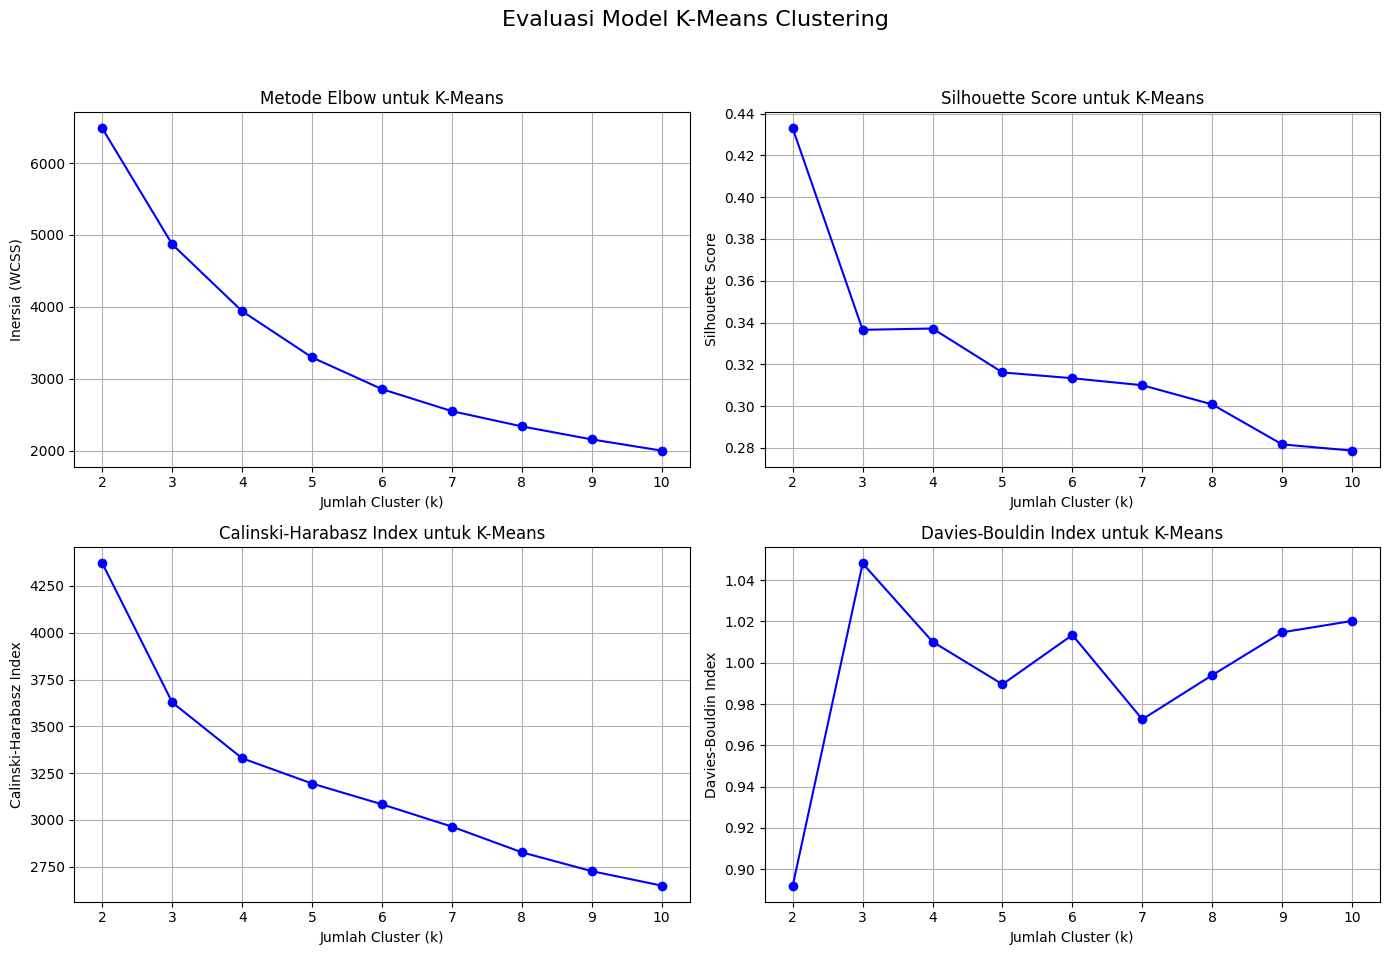

In [16]:
# Visualisasi Hasil Evaluasi ---

# Plot untuk K-Means
plt.figure(figsize=(14, 10))
plt.suptitle('Evaluasi Model K-Means Clustering', fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inersia (WCSS)')
plt.title('Metode Elbow untuk K-Means')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(K, silhouette, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk K-Means')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(K, calinski, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index untuk K-Means')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(K, davies, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index untuk K-Means')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('kmeans_metrics_evaluation.png')

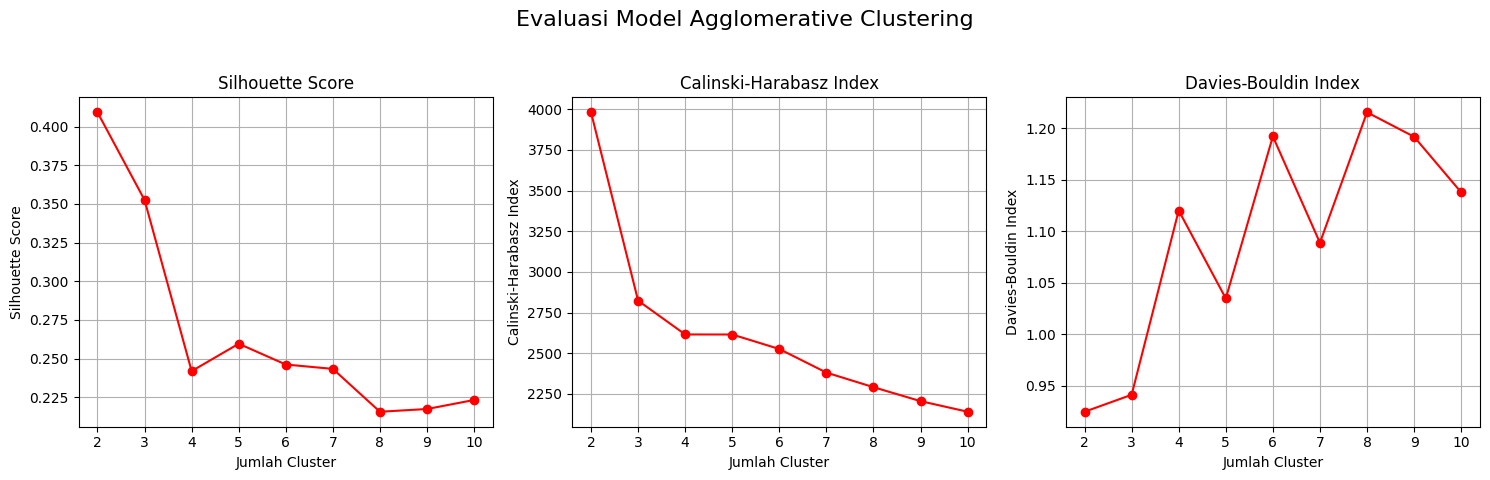

In [17]:
# Plot untuk Agglomerative Clustering
plt.figure(figsize=(15, 5))
plt.suptitle('Evaluasi Model Agglomerative Clustering', fontsize=16)

plt.subplot(1, 3, 1)
plt.plot(K, silhouette_agg, 'ro-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(K, calinski_agg, 'ro-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(K, davies_agg, 'ro-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('agglomerative_metrics_evaluation.png')

# Tampilkan plot jika dijalankan dalam lingkungan yang mendukung
plt.show()
